# LSTM neural network for traffic flow predictions
This notebook contains the code for applying neural network models to smart city data <br>


In [ ]:
# GPU check:

import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
print("Show System RAM Memory: \n \n")
!cat /proc/meminfo | egrep "MemTotal"
device_lib.list_local_devices()

Show System RAM Memory: 
 

MemTotal:       26751732 kB


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10378287523115679844, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17279323666549616520
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10613793688685596393
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15695549568
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7705261644096431565
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [ ]:
# get additional info about the hardware in the cloud
%cat /proc/cpuinfo
%cat /proc/meminfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

Tutorial about google colab and GPU access: <br>
https://www.youtube.com/watch?v=f1UK8KPt-KU

In [ ]:
# this allows for accessing files stored in your google drive using the path "/gdrive/My Drive/"
# mounting google drive locally:

from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
# importing local data to google colab:
from google.colab import files
uploaded = files.upload()

Saving taxi_series_H to taxi_series_H


$\textbf{Background:}$ Tensors are data structures that you can think of as multi-dimensional arrays. Tensors are represented as n-dimensional arrays of base dataypes such as a string or integer -- they provide a way to generalize vectors and matrices to higher dimensions. The shape of a Tensor defines its number of dimensions and the size of each dimension. The rank of a Tensor provides the number of dimensions. Scalars can be used to create 0-d Tensors. Vectors and lists can be used to create 1-d Tensors. Matrices can be used to create 2-d or higher rank Tensors. The shape of a Tensor provides the number of elements in each Tensor dimension.

$\textbf{Neural Networks in Tensorflow:}$ We can also define neural networks in TensorFlow. TensorFlow uses a high-level API called Keras that provides a powerful, intuitive framework for building and training deep learning models. <br> 
Tensors can flow through abstract types called $\textit{Layers}$ -- the building blocks of neural networks. Layers implement common neural networks operations, and are used to update weights, compute losses, and define inter-layer connectivity <br>
<br>
Conveniently, TensorFlow has defined a number of Layers that are commonly used in neural networks, for example a Dense. Now, instead of using a single Layer to define our simple neural network, we'll use the Sequential model from Keras and a single Dense layer to define our network. With the Sequential API, you can readily create neural networks by stacking together layers like building blocks.

# Implementation

In [ ]:
## -- Packages  -- ##

# General
import pandas as pd
import numpy as np

# Time formatting
import datetime

# Load and save data
import pickle
# progress bar
from tqdm import tqdm

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
#import tikzplotlib as tkz

In [ ]:
##  NN libaries ##
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt


## ML libraries ##
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler

In [ ]:
## Set random seed for reproducable results. see https://machinelearningmastery.com/reproducible-results-neural-networks-keras/ and https://stackoverflow.com/questions/58638701/importerror-cannot-import-name-set-random-seed-from-tensorflow-c-users-po
from numpy.random import seed
seed(123)
#from tensorflow.random import set_random_seed
tf.random.set_seed(123)

### Load data

In [ ]:
#load taxi data. Generated in notebook 'taxi_trips'
filename = '/gdrive/My Drive/Colab Notebooks/taxi_series_H'
infile = open(filename,'rb')
taxi_ts = pickle.load(infile)
infile.close()

In [ ]:
taxi_ts.shape

(8760,)

### Preprocessing

In [ ]:
## Remove last 24 hours as well as the part of test set not being used for main results
taxi_ts = taxi_ts.iloc[0:-192]
taxi_ts.shape

(8568,)

In [ ]:
## Set paramaters
input_lags = 60 # 2 and a half times the seasonal period
output_lags = 24 # we predict 24 hours ahead
n_test = 24 # output_lags  (changed)


In [ ]:
## Split data in train and test set
train = taxi_ts[0:-n_test]
test = taxi_ts[-n_test:]
print(train.shape)
print(test.shape)

(8544,)
(24,)


In [ ]:
## Create lagged values for both input and output window (24)
data = train.copy()
n_train = len(data)

##Create lagged values for input
df = pd.DataFrame()
for i in range(input_lags,0,-1):
    df['t-' + str(i)] = data.shift(i)

##Create lagged values for output
for j in range(0,output_lags,1):
    df['t+' + str(j)] = data.shift(-j)
    
df = df[input_lags:(n_train-output_lags+1)]

In [ ]:
df.head()

,t-60,t-59,t-58,t-57,t-56,t-55,t-54,t-53,t-52,t-51,t-50,t-49,t-48,t-47,t-46,t-45,t-44,t-43,t-42,t-41,t-40,t-39,t-38,t-37,t-36,t-35,t-34,t-33,t-32,t-31,t-30,t-29,t-28,t-27,t-26,t-25,t-24,t-23,t-22,t-21,...,t-16,t-15,t-14,t-13,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t+0,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9,t+10,t+11,t+12,t+13,t+14,t+15,t+16,t+17,t+18,t+19,t+20,t+21,t+22,t+23
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-03 12:00:00,11510.0,9596.0,7984.0,5919.0,4414.0,2251.0,2725.0,3720.0,5547.0,8934.0,10842.0,12045.0,13286.0,14658.0,14261.0,13059.0,12673.0,14327.0,13896.0,12740.0,11350.0,11197.0,9885.0,8741.0,4915.0,2747.0,1652.0,1173.0,1318.0,2682.0,6690.0,9618.0,12715.0,13279.0,12110.0,12133.0,13245.0,14139.0,14624.0,14278.0,...,12759.0,12897.0,11317.0,8075.0,4866.0,2737.0,1587.0,1156.0,1172.0,2520.0,6333.0,9554.0,12878.0,13005.0,12508.0,12509.0,14326,16733.0,15450.0,14738.0,14632.0,16585.0,16488.0,12862.0,11051.0,11540.0,11029.0,10140.0,8339.0,6441.0,4764.0,3385.0,2489.0,1651.0,2388.0,3018.0,3847.0,5269.0,6621.0,8176.0
2018-07-03 13:00:00,9596.0,7984.0,5919.0,4414.0,2251.0,2725.0,3720.0,5547.0,8934.0,10842.0,12045.0,13286.0,14658.0,14261.0,13059.0,12673.0,14327.0,13896.0,12740.0,11350.0,11197.0,9885.0,8741.0,4915.0,2747.0,1652.0,1173.0,1318.0,2682.0,6690.0,9618.0,12715.0,13279.0,12110.0,12133.0,13245.0,14139.0,14624.0,14278.0,13545.0,...,12897.0,11317.0,8075.0,4866.0,2737.0,1587.0,1156.0,1172.0,2520.0,6333.0,9554.0,12878.0,13005.0,12508.0,12509.0,14326.0,16733,15450.0,14738.0,14632.0,16585.0,16488.0,12862.0,11051.0,11540.0,11029.0,10140.0,8339.0,6441.0,4764.0,3385.0,2489.0,1651.0,2388.0,3018.0,3847.0,5269.0,6621.0,8176.0,9131.0
2018-07-03 14:00:00,7984.0,5919.0,4414.0,2251.0,2725.0,3720.0,5547.0,8934.0,10842.0,12045.0,13286.0,14658.0,14261.0,13059.0,12673.0,14327.0,13896.0,12740.0,11350.0,11197.0,9885.0,8741.0,4915.0,2747.0,1652.0,1173.0,1318.0,2682.0,6690.0,9618.0,12715.0,13279.0,12110.0,12133.0,13245.0,14139.0,14624.0,14278.0,13545.0,14945.0,...,11317.0,8075.0,4866.0,2737.0,1587.0,1156.0,1172.0,2520.0,6333.0,9554.0,12878.0,13005.0,12508.0,12509.0,14326.0,16733.0,15450,14738.0,14632.0,16585.0,16488.0,12862.0,11051.0,11540.0,11029.0,10140.0,8339.0,6441.0,4764.0,3385.0,2489.0,1651.0,2388.0,3018.0,3847.0,5269.0,6621.0,8176.0,9131.0,10124.0
2018-07-03 15:00:00,5919.0,4414.0,2251.0,2725.0,3720.0,5547.0,8934.0,10842.0,12045.0,13286.0,14658.0,14261.0,13059.0,12673.0,14327.0,13896.0,12740.0,11350.0,11197.0,9885.0,8741.0,4915.0,2747.0,1652.0,1173.0,1318.0,2682.0,6690.0,9618.0,12715.0,13279.0,12110.0,12133.0,13245.0,14139.0,14624.0,14278.0,13545.0,14945.0,16542.0,...,8075.0,4866.0,2737.0,1587.0,1156.0,1172.0,2520.0,6333.0,9554.0,12878.0,13005.0,12508.0,12509.0,14326.0,16733.0,15450.0,14738,14632.0,16585.0,16488.0,12862.0,11051.0,11540.0,11029.0,10140.0,8339.0,6441.0,4764.0,3385.0,2489.0,1651.0,2388.0,3018.0,3847.0,5269.0,6621.0,8176.0,9131.0,10124.0,9832.0
2018-07-03 16:00:00,4414.0,2251.0,2725.0,3720.0,5547.0,8934.0,10842.0,12045.0,13286.0,14658.0,14261.0,13059.0,12673.0,14327.0,13896.0,12740.0,11350.0,11197.0,9885.0,8741.0,4915.0,2747.0,1652.0,1173.0,1318.0,2682.0,6690.0,9618.0,12715.0,13279.0,12110.0,12133.0,13245.0,14139.0,14624.0,14278.0,13545.0,14945.0,16542.0,14673.0,...,4866.0,2737.0,1587.0,1156.0,1172.0,2520.0,6333.0,9554.0,12878.0,13005.0,12508.0,12509.0,14326.0,16733.0,15450.0,14738.0,14632,16585.0,16488.0,12862.0,11051.0,11540.0,11029.0,10140.0,8339.0,6441.0,4764.0,3385.0,2489.0,1651.0,2388.0,3018.0,3847.0,5269.0,6621.0,8176.0,9131.0,10124.0,9832.0,9478.0


In [ ]:
## splitting the training set into labels and features
X_train = df.iloc[:,:input_lags] # from the beginning to input_lags
Y_train = df.iloc[:,input_lags:] # from input_lags to the end

## Use the last window of the training set as the features for the test set. This requires a combination of 
## X_train and Y_train.
X_test = X_train.iloc[len(X_train) - 1,:][output_lags:]
X_test = X_test.append(Y_train.iloc[len(Y_train) - 1,:]).values.reshape(1,input_lags)
Y_test = test[:output_lags].values.reshape(1,output_lags)

X_train = X_train.values # 54 steps back (54 lags)
Y_train = Y_train.values # 24 steps ahead

print("X_train: " + "type: " + str(type(X_train)) + "\tshape: " + str(X_train.shape))
print("Y_train: " + "type: " + str(type(Y_train)) + "\tshape: " + str(Y_train.shape))
print("X_test: " + "type: " + str(type(X_test)) + "\tshape: " + str(X_test.shape))
print("Y_test: " + "type: " + str(type(Y_test)) + "\tshape: " + str(Y_test.shape))

X_train: type: <class 'numpy.ndarray'>	shape: (8461, 60)
Y_train: type: <class 'numpy.ndarray'>	shape: (8461, 24)
X_test: type: <class 'numpy.ndarray'>	shape: (1, 60)
Y_test: type: <class 'numpy.ndarray'>	shape: (1, 24)


$\textbf{When Should You Use Normalization And Standardization:}$

Normalization is a good technique to use when you do not know the distribution of your data or when you know the distribution is not Gaussian (a bell curve). Normalization is useful when your data has varying scales and the algorithm you are using does not make assumptions about the distribution of your data, such as k-nearest neighbors and artificial neural networks.

In [ ]:
## normalizing the data

# MinMaxScaler() transforms features by scaling each feature to a given range (given by feature_range())
# The cost of having this bounded range is that we will end up with smaller standard deviations, which can 
# suppress the effect of outliers. Thus MinMax Scalar is sensitive to outliers

#scaler = MinMaxScaler(feature_range=(0, 1))
#df_x = df.iloc[:,0:24]
# the method fit_transform() computes the min and the max used for scaling and then carries out the transformation
#df_x_scaled = scaler.fit_transform(df_x)
# later, inverse_transform() can be used to undo the scaling to the feature_range

# normalizing the entire dataset
#df_normalized = scaler.fit_transform(df)

# Building the LSTM neural network model

# Method 1 (Keras)

Tensorflow 2.0 Impelementation <br>
(tf.keras is TensorFlow's implementation of the Keras API specification. This is a high-level API to build and train models that includes first-class support for TensorFlow-specific functionality)


TF 2 keras RNN tutorial
https://www.tensorflow.org/guide/keras/rnn <br>
TF 2 time series forecasting tutorial
https://www.tensorflow.org/tutorials/structured_data/time_series

In [ ]:
# configuring the inputs for the model
# For Keras, the input has to be in the shape (samples, time steps, features)
# 24 timestep with n features where n is equal to the shape of column [1] of X_train or X_test

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
X_train.shape

(8461, 1, 60)

In [ ]:
X_test.shape

(1, 1, 60)

In [ ]:
# creating a leaky_relu activation function

def my_leaky_relu(x):
    return tf.nn.leaky_relu(x)

## Gridsearch CV for the optimal hyperparameters

Guide to Hyperparameter tuning: <br>
https://towardsdatascience.com/simple-guide-to-hyperparameter-tuning-in-neural-networks-3fe03dad8594
Dropout regularization for RNNs: <br>
https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/

## One step Gridsearch CV for all hyperparameters

**Blogpost Hyperparametertuning LSTM/GRU:**

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

**Overview of Gradient Descent Algorithms:**

https://ruder.io/optimizing-gradient-descent/index.html#adagrad

In [ ]:
# creating the parameter grid as a dictionary

## FULL GRID ##
batch_size = [100, 250, 500]
epochs = [250, 500, 750]
neurons = [500, 1000, 1500]
dropout = [0.0]
learning_rate = [0.001, 0.01]
optimizer = ['Adagrad', 'Adam', 'Adadelta']
#optimizer = ["Adam"]

param_grid_cv = dict(batch_size=batch_size, epochs=epochs, neurons=neurons, dropout = dropout, optimizer=optimizer, learning_rate = learning_rate)

In [ ]:
## REDUCED GRID ##
batch_size = [200, 300]
epochs = [200, 300]
neurons = [500, 1000, 1500]
dropout = [0.0, 0.2]
learning_rate = [0.001]

param_grid_cv = dict(batch_size=batch_size, epochs=epochs, neurons=neurons, dropout = dropout, learning_rate = learning_rate)
# fixed learning rate at 0.001 seems to work best, "leaky relu" activation function seems to work best, dropout seems to lower the test error

In [ ]:
# setting up the model (1HL)
# the default activation function is tanh()

def model(neurons = 128, epochs = 100, batch_size =100, dropout = 0.0, learning_rate = 0.001, optimizer="Adam"):
    model = tf.keras.Sequential()

# embedding layer expecting input dimension of size 1000 and an output dimension of size 64.
# i.e. the model will take as input an integer matrix of size (batch_size, input_length)
# and it will turn positive integers (indexes) into dense vectors of fixed size.
#model.add(tf.keras.layers.Embedding(input_dim=1000, output_dim=64))

# Add a GRU layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 128)
    model.add(tf.keras.layers.LSTM(units=neurons, return_sequences = False, input_shape = (1,60), dropout = dropout, activation = my_leaky_relu))

# output layer with 24 neurons
    model.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mean_squared_error'])
    
    return model


In [ ]:
## 2HL 


# setting up the model
# the default activation function is tanh()

def model(neurons = 128, epochs = 100, batch_size =100, dropout = 0.0, learning_rate = 0.001, optimizer="Adam"):
    model = tf.keras.Sequential()

# Add a GRU layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 128)
    model.add(tf.keras.layers.LSTM(units=neurons, return_sequences = True, input_shape = (1,60), dropout = dropout, activation = my_leaky_relu))

    model.add(tf.keras.layers.LSTM(units=neurons, return_sequences = False, input_shape = (1,60), dropout = dropout, activation = my_leaky_relu))

# output layer with 24 neurons
    model.add(tf.keras.layers.Dense(24))

    
# the compile() method configures the model for training
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mean_squared_error'])
    
    return model

In [ ]:
## 3HL 


# setting up the model
# the default activation function is tanh()

def model(neurons = 128, epochs = 100, batch_size =100, dropout = 0.0, learning_rate = 0.001, optimizer="Adam"):
    model = tf.keras.Sequential()

# embedding layer expecting input dimension of size 1000 and an output dimension of size 64.
# i.e. the model will take as input an integer matrix of size (batch_size, input_length)
# and it will turn positive integers (indexes) into dense vectors of fixed size.
#model.add(tf.keras.layers.Embedding(input_dim=1000, output_dim=64))

# Add a GRU layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 128)
    model.add(tf.keras.layers.LSTM(units=neurons, return_sequences = True, input_shape = (1,60), dropout = dropout, activation = my_leaky_relu))

    model.add(tf.keras.layers.LSTM(units=neurons, return_sequences = True, input_shape = (1,60), dropout = dropout, activation = my_leaky_relu))

    model.add(tf.keras.layers.LSTM(units=neurons, return_sequences = False, input_shape = (1,60), dropout = dropout, activation = my_leaky_relu))

# output layer with 24 neurons
    model.add(tf.keras.layers.Dense(24))

    
# the compile() method configures the model for training
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mean_squared_error'])
    
    return model

In [ ]:
# using the KerasRegressor as a wrapper to carry out the GridSearchCV
model_cv = KerasRegressor(build_fn = model, verbose=1)

In [ ]:
# k fold CV 1 HL
inner_splits = 3
inner_loop = TimeSeriesSplit(n_splits = inner_splits).split(X_train,Y_train)

# n_jobs set to 4 means that 4 cores are used for parallel processing; set n_jobs=-1 to use all available cores

grid_cv = GridSearchCV(estimator = model_cv, param_grid = param_grid_cv, cv = inner_loop, verbose = 3, n_jobs=-1)
grid_result = grid_cv.fit(X_train,Y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 81.7min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 175.3min


[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed: 251.9min finished


Epoch 1/750
34/34 [==============================] - 0s 6ms/step - loss: 25141380.0000 - mean_squared_error: 25141380.0000
Epoch 2/750
34/34 [==============================] - 0s 5ms/step - loss: 8543540.0000 - mean_squared_error: 8543540.0000
Epoch 3/750
34/34 [==============================] - 0s 5ms/step - loss: 7549188.0000 - mean_squared_error: 7549188.0000
Epoch 4/750
34/34 [==============================] - 0s 5ms/step - loss: 6767271.5000 - mean_squared_error: 6767271.5000
Epoch 5/750
34/34 [==============================] - 0s 5ms/step - loss: 6022767.0000 - mean_squared_error: 6022767.0000
Epoch 6/750
34/34 [==============================] - 0s 5ms/step - loss: 5509521.5000 - mean_squared_error: 5509521.5000
Epoch 7/750
34/34 [==============================] - 0s 5ms/step - loss: 5127264.5000 - mean_squared_error: 5127264.5000
Epoch 8/750
34/34 [==============================] - 0s 5ms/step - loss: 4782981.5000 - mean_squared_error: 4782981.5000
Epoch 9/750
34/34 [===========

In [ ]:
# summarize results 1 HL
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -2306888.458333 using {'batch_size': 250, 'dropout': 0.0, 'epochs': 750, 'learning_rate': 0.001, 'neurons': 1500, 'optimizer': 'Adagrad'}
-2574283.666667 (987713.697909) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 500, 'optimizer': 'Adagrad'}
-2685801.708333 (1071101.317876) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 500, 'optimizer': 'Adam'}
-2718734.541667 (1031859.288797) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 500, 'optimizer': 'Adadelta'}
-2458543.541667 (990213.987913) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 1000, 'optimizer': 'Adagrad'}
-2555289.500000 (1103704.434217) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 1000, 'optimizer': 'Adam'}
-2488967.708333 (1016220.743298) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, '

In [ ]:
# k fold CV 2 HL
inner_splits = 3
inner_loop = TimeSeriesSplit(n_splits = inner_splits).split(X_train,Y_train)

# n_jobs set to 4 means that 4 cores are used for parallel processing; set n_jobs=-1 to use all available cores

grid_cv = GridSearchCV(estimator = model_cv, param_grid = param_grid_cv, cv = inner_loop, verbose = 3, n_jobs=-1)
grid_result = grid_cv.fit(X_train,Y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 169.6min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 376.8min


[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed: 563.0min finished


Epoch 1/250
85/85 [==============================] - 1s 10ms/step - loss: 16581890.0000 - mean_squared_error: 16581890.0000
Epoch 2/250
85/85 [==============================] - 1s 10ms/step - loss: 5587032.5000 - mean_squared_error: 5587033.0000
Epoch 3/250
85/85 [==============================] - 1s 10ms/step - loss: 4463783.0000 - mean_squared_error: 4463783.0000
Epoch 4/250
85/85 [==============================] - 1s 10ms/step - loss: 3925761.2500 - mean_squared_error: 3925761.2500
Epoch 5/250
85/85 [==============================] - 1s 10ms/step - loss: 3648784.5000 - mean_squared_error: 3648784.5000
Epoch 6/250
85/85 [==============================] - 1s 10ms/step - loss: 3320489.5000 - mean_squared_error: 3320489.5000
Epoch 7/250
85/85 [==============================] - 1s 10ms/step - loss: 2924588.7500 - mean_squared_error: 2924588.7500
Epoch 8/250
85/85 [==============================] - 1s 10ms/step - loss: 2776084.0000 - mean_squared_error: 2776084.0000
Epoch 9/250
85/85 [===

In [ ]:
# summarize results 2 HL
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -2198221.083333 using {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 1500, 'optimizer': 'Adagrad'}
-2321168.270833 (935078.606765) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 500, 'optimizer': 'Adagrad'}
-2375201.833333 (944922.061926) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 500, 'optimizer': 'Adam'}
-2344902.208333 (957491.232246) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 500, 'optimizer': 'Adadelta'}
-2244535.187500 (907309.446187) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 1000, 'optimizer': 'Adagrad'}
-2337937.375000 (814695.733002) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 1000, 'optimizer': 'Adam'}
-2338089.166667 (922257.107513) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'lear

In [ ]:
# k fold CV 3 HL
inner_splits = 3
inner_loop = TimeSeriesSplit(n_splits = inner_splits).split(X_train,Y_train)

# n_jobs set to 4 means that 4 cores are used for parallel processing; set n_jobs=-1 to use all available cores

grid_cv = GridSearchCV(estimator = model_cv, param_grid = param_grid_cv, cv = inner_loop, verbose = 3, n_jobs=-1)
grid_result = grid_cv.fit(X_train,Y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 242.3min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 552.3min


In [ ]:
# summarize results 3HL
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -2186373.875000 using {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 1500, 'optimizer': 'Adagrad'}
-2344298.833333 (964036.526521) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 500, 'optimizer': 'Adagrad'}
-2346067.729167 (945756.220119) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 500, 'optimizer': 'Adam'}
-2319258.750000 (969153.406978) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 500, 'optimizer': 'Adadelta'}
-2262295.812500 (915136.290022) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 1000, 'optimizer': 'Adagrad'}
-2241415.666667 (912003.398407) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'learning_rate': 0.001, 'neurons': 1000, 'optimizer': 'Adam'}
-2295157.333333 (840062.932528) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 250, 'lear

## Fitting the optimal model with all gridsearched parameters

In [ ]:


# fitting the optimal GRU model with the gridsearched hyperparameters
LSTM_model = tf.keras.Sequential()

# Add a GRU layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 128)
LSTM_model.add(tf.keras.layers.LSTM(units=1500, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# output layer 
LSTM_model.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
LSTM_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate = 0.001),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mean_squared_error'])
LSTM_model.fit(X_train, Y_train, epochs= 750, batch_size=250, verbose=1)
    


Epoch 1/750
29/29 [==============================] - 0s 6ms/step - loss: 26862134.0000 - mean_squared_error: 26862134.0000
Epoch 2/750
29/29 [==============================] - 0s 6ms/step - loss: 8849576.0000 - mean_squared_error: 8849576.0000
Epoch 3/750
29/29 [==============================] - 0s 6ms/step - loss: 7609321.0000 - mean_squared_error: 7609321.0000
Epoch 4/750
29/29 [==============================] - 0s 6ms/step - loss: 6850656.0000 - mean_squared_error: 6850656.0000
Epoch 5/750
29/29 [==============================] - 0s 6ms/step - loss: 6349058.5000 - mean_squared_error: 6349058.5000
Epoch 6/750
29/29 [==============================] - 0s 6ms/step - loss: 5757928.0000 - mean_squared_error: 5757928.0000
Epoch 7/750
29/29 [==============================] - 0s 6ms/step - loss: 5304128.0000 - mean_squared_error: 5304128.0000
Epoch 8/750
29/29 [==============================] - 0s 6ms/step - loss: 5063600.5000 - mean_squared_error: 5063600.5000
Epoch 9/750
29/29 [===========

In [ ]:
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1500)              9366000   
_________________________________________________________________
dense (Dense)                (None, 24)                36024     
Total params: 9,402,024
Trainable params: 9,402,024
Non-trainable params: 0
_________________________________________________________________


Deep GRU network (input layer - 2 stacked GRU hidden layers - output layer)


In [ ]:
# To stack GRU layers, we need to change the configuration of the prior GRU layer to output a 3D array as input for the subsequent layer.
# We can do this by setting the return_sequences argument on the layer to True (the default is False). 
# This will return one output for each input time step and provide a 3D array.

# fitting the optimal GRU model with the gridsearched hyperparameters
Deep_LSTM_model = tf.keras.Sequential()

# Add a GRU layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 128)
Deep_LSTM_model.add(tf.keras.layers.LSTM(units=1500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# 2nd GRU hidden layer
Deep_LSTM_model.add(tf.keras.layers.LSTM(units=1500, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))


# output layer with 10 ne
Deep_LSTM_model.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
Deep_LSTM_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate = 0.001),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mean_squared_error'])
Deep_LSTM_model.fit(X_train, Y_train, epochs=250, batch_size= 100, verbose=1)



Epoch 1/250
12/12 [==============================] - 0s 23ms/step - loss: 52663296.0000 - mean_squared_error: 52663296.0000
Epoch 2/250
12/12 [==============================] - 0s 22ms/step - loss: 11351333.0000 - mean_squared_error: 11351333.0000
Epoch 3/250
12/12 [==============================] - 0s 22ms/step - loss: 8669365.0000 - mean_squared_error: 8669365.0000
Epoch 4/250
12/12 [==============================] - 0s 22ms/step - loss: 7408638.0000 - mean_squared_error: 7408638.0000
Epoch 5/250
12/12 [==============================] - 0s 22ms/step - loss: 6740358.5000 - mean_squared_error: 6740358.5000
Epoch 6/250
12/12 [==============================] - 0s 22ms/step - loss: 6208516.5000 - mean_squared_error: 6208516.5000
Epoch 7/250
12/12 [==============================] - 0s 22ms/step - loss: 5793091.5000 - mean_squared_error: 5793091.5000
Epoch 8/250
12/12 [==============================] - 0s 22ms/step - loss: 5320327.0000 - mean_squared_error: 5320327.0000
Epoch 9/250
12/12 [=

Deep GRU network (input layer - 3 stacked GRU layers - output layer)

In [ ]:
# To stack GRU layers, we need to change the configuration of the prior GRU layer to output a 3D array as input for the subsequent layer.
# We can do this by setting the return_sequences argument on the layer to True (the default is False). 
# This will return one output for each input time step and provide a 3D array.

# fitting the optimal GRU model with the gridsearched hyperparameters
Deep_LSTM_model2 = tf.keras.Sequential()

# Add a GRU layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 128)
Deep_LSTM_model2.add(tf.keras.layers.LSTM(units=1500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# 2nd GRU hidden layer
Deep_LSTM_model2.add(tf.keras.layers.LSTM(units=1500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# 3rd GRU hidden layer
Deep_LSTM_model2.add(tf.keras.layers.LSTM(units=1500, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# output layer with 10 ne
Deep_LSTM_model2.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
Deep_LSTM_model2.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate = 0.001),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mean_squared_error'])
Deep_LSTM_model2.fit(X_train, Y_train, epochs=250, batch_size= 100, verbose=1)

Epoch 1/250
85/85 [==============================] - 1s 14ms/step - loss: 17956498.0000 - mean_squared_error: 17956498.0000
Epoch 2/250
85/85 [==============================] - 1s 14ms/step - loss: 7844247.5000 - mean_squared_error: 7844247.0000
Epoch 3/250
85/85 [==============================] - 1s 14ms/step - loss: 6976060.5000 - mean_squared_error: 6976060.5000
Epoch 4/250
85/85 [==============================] - 1s 13ms/step - loss: 6376880.0000 - mean_squared_error: 6376880.0000
Epoch 5/250
85/85 [==============================] - 1s 14ms/step - loss: 5864945.5000 - mean_squared_error: 5864945.5000
Epoch 6/250
85/85 [==============================] - 1s 14ms/step - loss: 5768799.5000 - mean_squared_error: 5768799.5000
Epoch 7/250
85/85 [==============================] - 1s 14ms/step - loss: 5447339.5000 - mean_squared_error: 5447339.5000
Epoch 8/250
85/85 [==============================] - 1s 14ms/step - loss: 5205948.0000 - mean_squared_error: 5205948.0000
Epoch 9/250
85/85 [===

Deep GRU network (input layer - 5 stacked GRU layers - output layer)

In [ ]:
# To stack GRU layers, we need to change the configuration of the prior GRU layer to output a 3D array as input for the subsequent layer.
# We can do this by setting the return_sequences argument on the layer to True (the default is False). 
# This will return one output for each input time step and provide a 3D array.

# fitting the optimal GRU model with the gridsearched hyperparameters
Deep_LSTM_model3 = tf.keras.Sequential()

# Add a GRU layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 128)
Deep_LSTM_model3.add(tf.keras.layers.LSTM(units=1500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# 2nd GRU hidden layer
Deep_LSTM_model3.add(tf.keras.layers.LSTM(units=1500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# 3rd GRU hidden layer
Deep_LSTM_model3.add(tf.keras.layers.LSTM(units=1500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# 4th GRU hidden layer
Deep_LSTM_model3.add(tf.keras.layers.LSTM(units=1500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# 5th GRU hidden layer
Deep_LSTM_model3.add(tf.keras.layers.LSTM(units=1500, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

# output layer 
Deep_LSTM_model3.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
Deep_LSTM_model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mean_squared_error'])
Deep_LSTM_model3.fit(X_train, Y_train, epochs=500, batch_size=250, verbose=1)

## Undoing the normalization, making predictions and computing the test error

In [ ]:
# making predictions (regular GRU)
y_train_pred = LSTM_model.predict(X_train)
y_test_pred = LSTM_model.predict(X_test)

# making predictions (deep GRU 2 hidden layers)
y_train_pred_deep = Deep_LSTM_model.predict(X_train)
y_test_pred_deep = Deep_LSTM_model.predict(X_test)

# making predictions (deep GRU 3 hidden layers)
y_train_pred_deep2 = Deep_LSTM_model2.predict(X_train)
y_test_pred_deep2 = Deep_LSTM_model2.predict(X_test)

# making predictions (deep GRU 5 hidden layers)
#y_train_pred_deep3 = Deep_LSTM_model3.predict(X_train)
#y_test_pred_deep3 = Deep_LSTM_model3.predict(X_test)

In [ ]:
# MSE LSTM forecast
mse_LSTM = mean_squared_error(Y_test, y_test_pred)
mse_LSTM

450904.4346247266

In [ ]:
# RMSE LSTM forecast
rmse_LSTM = sqrt(mse_LSTM)
rmse_LSTM

671.4941806335529

In [ ]:
# mae LSTM
mae_LSTM = mean_absolute_error(Y_test, y_test_pred)
mae_LSTM

554.6144612630209

In [ ]:
# MSE Deep LSTM forecast (2HL)
mse_LSTM1 = mean_squared_error(Y_test, y_test_pred_deep)
mse_LSTM1

278832.9568669523

In [ ]:
# RMSE Deep GRU forecast (2HL)
rmse_LSTM1 = sqrt(mse_LSTM1)
rmse_LSTM1

528.046358634308

In [ ]:
# mae DeepGRU (2HL)
mae_LSTM1 = mean_absolute_error(Y_test, y_test_pred_deep)
mae_LSTM1

439.6496073404948

In [ ]:
# MSE Deep GRU forecast (3HL)
mse_LSTM2 = mean_squared_error(Y_test, y_test_pred_deep2)
mse_LSTM2

2259734.298464949

In [ ]:
# RMSE Deep GRU forecast (3HL)
rmse_LSTM2 = sqrt(mse_LSTM2)
rmse_LSTM2

1503.2412642237268

In [ ]:
# mae DeepGRU (3HL)
mae_LSTM2 = mean_absolute_error(Y_test, y_test_pred_deep2)
mae_LSTM2

1226.8157755533855

In [ ]:
# MSE Deep LSTM forecast (5HL)
mse_LSTM3 = mean_squared_error(Y_test, y_test_pred_deep3)
mse_LSTM3

1171140.051866278

In [ ]:
# RMSE Deep GRU forecast (5HL)
rmse_LSTM3 = sqrt(mse_LSTM3)
rmse_LSTM3

1082.1922434883177

In [ ]:
# mae DeepGRU (5HL)
mae_LSTM2 = mean_absolute_error(Y_test, y_test_pred_deep3)
mae_LSTM2

978.8323364257812

In [ ]:
# custom MAPE function
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_true = Y_test
y_pred = y_test_pred_deep



In [ ]:
# MAPE GRU 1 HL
y_true = Y_test
y_pred = y_test_pred

mean_absolute_percentage_error(y_true,y_pred)

In [ ]:
# MAPE GRU 2 HL
y_true = Y_test
y_pred = y_test_pred_deep

mean_absolute_percentage_error(y_true,y_pred)

In [ ]:
# MAPE GRU 3 HL
y_true = Y_test
y_pred = y_test_pred_deep2

mean_absolute_percentage_error(y_true,y_pred)

In [ ]:
# MAPE GRU 5 HL
y_true = Y_test
y_pred = y_test_pred_deep3

mean_absolute_percentage_error(y_true,y_pred)

### Export point forecasts

In [ ]:
LSTM_preds = pd.Series(y_test_pred[0])
LSTM_preds_deep = pd.Series(y_test_pred_deep[0])

In [ ]:
# export the GRU predictions and the test data to google drive
from google.colab import  drive

drive.mount('/drive')

LSTM_preds.to_csv('/drive/My Drive/Colab Notebooks/LSTM_preds.csv', index=False)
LSTM_preds_deep.to_csv('/drive/My Drive/Colab Notebooks/LSTM_preds_deep.csv', index=False)

Mounted at /drive


## Prediction intervals using quantile regression

In [ ]:
# quantile regression loss = tilted loss = pinball loss
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

1 single PI network

In [ ]:
class LSTM_PI_model(tf.keras.Model):
    def __init__(self, input_shape = (1,60), output_shape = 24, alpha = 0.95, batch_size = 200):
        super(LSTM_PI_model, self).__init__()
        
        self.in_shape = input_shape
        self.out_shape = output_shape
        self.lower_alpha = (1-alpha)/2
        self.upper_alpha = (1-alpha)/2 + alpha
        self.batch_size = batch_size #move batch size to fit?
        
        self.loss_history = []
        
        ##define architechture 
        self.L1 = tf.keras.layers.LSTM(units=1000, input_shape = (self.in_shape,None), dropout = 0.0, return_sequences= False)
        #self.L2 = tf.keras.layers.Dense(units =24, activation = "relu")
        self.output_lowerPI = tf.keras.layers.Dense(self.out_shape)
        self.output_upperPI = tf.keras.layers.Dense(self.out_shape)
        
        ##define optimizer
        self.train_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        
    def call(self, X): # use predict() for forward pass outside fit
        #X = tf.dtypes.cast(X, tf.float32) 
        
        X = self.L1(X)
        output_lowerPI = self.output_lowerPI(X) 
        output_upperPI = self.output_upperPI(X)
        
        combined_output = [output_lowerPI, output_upperPI]
        return combined_output
    
    def get_loss(self, X, Y):
        
        Y_hat = self.call(X)
        output_lowerPI = Y_hat[0]
        output_upperPI = Y_hat[1]
        
        error_lower = tf.subtract(Y, output_lowerPI)
        loss_lower = tf.math.reduce_mean(tf.math.maximum(self.lower_alpha * error_lower, (self.lower_alpha - 1) * error_lower))
        
        error_upper = tf.subtract(Y, output_upperPI)
        loss_upper = tf.math.reduce_mean(tf.math.maximum(self.upper_alpha * error_upper, (self.upper_alpha - 1) * error_upper))
        
        combined_loss = tf.add(loss_lower,loss_upper)
        return combined_loss
        
    def get_grad(self, X, Y):
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            L = self.get_loss(X, Y)
        g = tape.gradient(L, self.trainable_variables)
        
        return L, g    
    
    def train_step(self, X, Y):
        L, g = self.get_grad(X, Y)
    
        self.train_opt.apply_gradients(zip(g, self.trainable_variables))
        
        return L
        
    def fit(self, X, Y, epochs = 300): 
        X = tf.dtypes.cast(X, tf.float32) ##layers use float 32, so cast data to fit
        Y = tf.dtypes.cast(Y, tf.float32) ##layers use float 32, so cast data to fit
        
        if hasattr(tqdm, '_instances'): tqdm._instances.clear() ## clear load bar if it is not empty

        loadbar = tqdm(range(epochs)) ##define loadbar with loop range, which is number of epochs
        for epoch in loadbar:
            loadbar.set_description("Epoch {}".format(epoch + 1))
            
            batch_losses = []
            for idx in range(0, X.shape[0], self.batch_size): ## get batches of size batch_size. NOT shuffled
                batch_X = X[idx : min(idx + self.batch_size, X.shape[0]),:]
                batch_Y = Y[idx : min(idx + self.batch_size, Y.shape[0]),:]
                L = self.train_step(batch_X, batch_Y)
                batch_losses.append(L.numpy())
        
            epoch_loss = np.mean(batch_losses)
            self.loss_history.append(np.mean(batch_losses))

# Crossvalidate

In [ ]:
# using the KerasRegressor as a wrapper to carry out the GridSearchCV
model = LSTM_PI_model(input_shape =  (1,60), output_shape = 24, alpha = 0.95)
model_cv = KerasRegressor(build_fn = lower_PI_model, verbose=1)

In [ ]:
# k fold CV
inner_splits = 3
inner_loop = TimeSeriesSplit(n_splits = inner_splits).split(X_train,Y_train)

# n_jobs set to 4 means that 4 cores are used for parallel processing; set n_jobs=-1 to use all available cores

grid_cv = GridSearchCV(estimator = model_cv, param_grid = param_grid_cv, cv = inner_loop, verbose = 3, n_jobs=-1)
grid_result = grid_cv.fit(X_train,Y_train)

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -2272861.541667 using {'batch_size': 250, 'dropout': 0.0, 'epochs': 500, 'learning_rate': 0.001, 'neurons': 1500, 'optimizer': 'Adam'}
-3075741.875000 (1333039.126074) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 100, 'learning_rate': 0.001, 'neurons': 500, 'optimizer': 'Adagrad'}
-3064208.208333 (1290450.534871) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 100, 'learning_rate': 0.001, 'neurons': 500, 'optimizer': 'Adam'}
-3145767.208333 (1449977.113606) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 100, 'learning_rate': 0.001, 'neurons': 500, 'optimizer': 'Adadelta'}
-2778736.958333 (1257995.910298) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 100, 'learning_rate': 0.001, 'neurons': 1000, 'optimizer': 'Adagrad'}
-2883809.083333 (1178979.523536) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 100, 'learning_rate': 0.001, 'neurons': 1000, 'optimizer': 'Adam'}
-2861197.500000 (1176129.968019) with: {'batch_size': 100, 'dropout': 0.0, 'epochs': 100, 'l

Fitting the PI model

In [ ]:
model_95 = LSTM_PI_model(input_shape =  (1,60), output_shape = 24, batch_size = 200, alpha = 0.95)

In [ ]:
model_95.fit(X_train, Y_train, epochs = 300)

Epoch 300: 100%|██████████| 300/300 [02:27<00:00,  2.03it/s]


In [ ]:
## make predictions and format them for plotting
predictions_95 = model_95.predict(X_test)
lower_PI_preds_95 = predictions_95[0]
upper_PI_preds_95 = predictions_95[1]


lower_PI_preds_95 = pd.Series(lower_PI_preds_95.reshape(output_lags,))
lower_PI_preds_95.index = test.iloc[:output_lags].index
upper_PI_preds_95 = pd.Series(upper_PI_preds_95.reshape(output_lags,))
upper_PI_preds_95.index = test.iloc[:output_lags].index


2 separate PI networks

PI model for the LSTM with 1 HL

In [ ]:
## build lower bound with different loss (95% PI)
q = 0.025


# fitting the GRU model with the gridsearched hyperparameters
lower_PI_model = tf.keras.Sequential()

# Add a GRU layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 128)
lower_PI_model.add(tf.keras.layers.LSTM(units=1000, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))



# output layer with 10 neurons
lower_PI_model.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
lower_PI_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=lambda y,f: tilted_loss(q,y,f))
lower_PI_model.fit(X_train, Y_train, epochs=300, batch_size=200, verbose=1)

Epoch 1/300
43/43 [==============================] - 0s 4ms/step - loss: 178.6180
Epoch 2/300
43/43 [==============================] - 0s 4ms/step - loss: 133.1896
Epoch 3/300
43/43 [==============================] - 0s 4ms/step - loss: 125.7360
Epoch 4/300
43/43 [==============================] - 0s 4ms/step - loss: 123.3319
Epoch 5/300
43/43 [==============================] - 0s 4ms/step - loss: 124.7696
Epoch 6/300
43/43 [==============================] - 0s 4ms/step - loss: 120.1089
Epoch 7/300
43/43 [==============================] - 0s 4ms/step - loss: 116.4983
Epoch 8/300
43/43 [==============================] - 0s 4ms/step - loss: 115.4180
Epoch 9/300
43/43 [==============================] - 0s 4ms/step - loss: 113.3224
Epoch 10/300
43/43 [==============================] - 0s 4ms/step - loss: 112.1525
Epoch 11/300
43/43 [==============================] - 0s 4ms/step - loss: 111.8858
Epoch 12/300
43/43 [==============================] - 0s 4ms/step - loss: 108.7348
Epoch 13/300


In [ ]:
## build upper bound with different loss (95% PI)
q = 0.975


# fitting the GRU model with the gridsearched hyperparameters
upper_PI_model = tf.keras.Sequential()

# Add a GRU layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 128)
upper_PI_model.add(tf.keras.layers.LSTM(units=1000, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))


# output layer with 24 neurons
upper_PI_model.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
upper_PI_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=lambda y,f: tilted_loss(q,y,f))
upper_PI_model.fit(X_train, Y_train, epochs=300, batch_size=200, verbose=1)

Epoch 1/300
43/43 [==============================] - 0s 4ms/step - loss: 1438.8595
Epoch 2/300
43/43 [==============================] - 0s 4ms/step - loss: 219.8293
Epoch 3/300
43/43 [==============================] - 0s 4ms/step - loss: 187.5354
Epoch 4/300
43/43 [==============================] - 0s 4ms/step - loss: 174.6754
Epoch 5/300
43/43 [==============================] - 0s 4ms/step - loss: 162.5807
Epoch 6/300
43/43 [==============================] - 0s 4ms/step - loss: 153.8957
Epoch 7/300
43/43 [==============================] - 0s 4ms/step - loss: 148.5803
Epoch 8/300
43/43 [==============================] - 0s 4ms/step - loss: 143.6499
Epoch 9/300
43/43 [==============================] - 0s 4ms/step - loss: 139.5780
Epoch 10/300
43/43 [==============================] - 0s 4ms/step - loss: 136.3981
Epoch 11/300
43/43 [==============================] - 0s 4ms/step - loss: 133.1372
Epoch 12/300
43/43 [==============================] - 0s 4ms/step - loss: 131.3383
Epoch 13/300

In [ ]:
# predictions from PI models for 1 HL

lower_pred = lower_PI_model.predict(X_test)
upper_pred = upper_PI_model.predict(X_test)

PI model for the DLSTM with 2 HL






In [ ]:
## build lower bound with different loss (95% PI)
q = 0.025


# fitting the GRU model with the gridsearched hyperparameters
lower_PI_model = tf.keras.Sequential()

# Add a GRU layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 128)
lower_PI_model.add(tf.keras.layers.LSTM(units=500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

lower_PI_model.add(tf.keras.layers.LSTM(units=500, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))



# output layer with 10 neurons
lower_PI_model.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
lower_PI_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=lambda y,f: tilted_loss(q,y,f))
lower_PI_model.fit(X_train, Y_train, epochs=300, batch_size=200, verbose=1)


Epoch 1/300
43/43 [==============================] - 0s 6ms/step - loss: 212.8265
Epoch 2/300
43/43 [==============================] - 0s 6ms/step - loss: 140.8818
Epoch 3/300
43/43 [==============================] - 0s 5ms/step - loss: 132.2048
Epoch 4/300
43/43 [==============================] - 0s 5ms/step - loss: 126.3409
Epoch 5/300
43/43 [==============================] - 0s 6ms/step - loss: 123.5405
Epoch 6/300
43/43 [==============================] - 0s 6ms/step - loss: 121.4455
Epoch 7/300
43/43 [==============================] - 0s 6ms/step - loss: 116.7766
Epoch 8/300
43/43 [==============================] - 0s 5ms/step - loss: 115.1743
Epoch 9/300
43/43 [==============================] - 0s 6ms/step - loss: 112.6972
Epoch 10/300
43/43 [==============================] - 0s 6ms/step - loss: 110.3268
Epoch 11/300
43/43 [==============================] - 0s 6ms/step - loss: 109.7448
Epoch 12/300
43/43 [==============================] - 0s 6ms/step - loss: 106.9908
Epoch 13/300


In [ ]:
## build upper bound with different loss (95% PI)
q = 0.975


# fitting the GRU model with the gridsearched hyperparameters
upper_PI_model = tf.keras.Sequential()

# Add a GRU layer with 128 units (=dimensionality of the output space = number of neurons)
# option1: return sequences returns the hidden state output for each input time step.
# option2: return state returns the hidden state output and cell state for the last input time step.
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 128)
upper_PI_model.add(tf.keras.layers.LSTM(units=500, return_sequences = True, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))

upper_PI_model.add(tf.keras.layers.LSTM(units=500, return_sequences = False, input_shape = (1,60), activation=my_leaky_relu, dropout = 0.0))


# output layer with 24 neurons
upper_PI_model.add(tf.keras.layers.Dense(24))
# the compile() method configures the model for training
upper_PI_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=lambda y,f: tilted_loss(q,y,f))
upper_PI_model.fit(X_train, Y_train, epochs=300, batch_size=200, verbose=1)

Epoch 1/300
43/43 [==============================] - 0s 6ms/step - loss: 2292.1797
Epoch 2/300
43/43 [==============================] - 0s 6ms/step - loss: 220.8126
Epoch 3/300
43/43 [==============================] - 0s 6ms/step - loss: 192.6118
Epoch 4/300
43/43 [==============================] - 0s 6ms/step - loss: 180.1089
Epoch 5/300
43/43 [==============================] - 0s 6ms/step - loss: 168.1619
Epoch 6/300
43/43 [==============================] - 0s 6ms/step - loss: 156.5401
Epoch 7/300
43/43 [==============================] - 0s 7ms/step - loss: 149.0435
Epoch 8/300
43/43 [==============================] - 0s 6ms/step - loss: 143.7399
Epoch 9/300
43/43 [==============================] - 0s 6ms/step - loss: 140.1759
Epoch 10/300
43/43 [==============================] - 0s 6ms/step - loss: 135.4581
Epoch 11/300
43/43 [==============================] - 0s 6ms/step - loss: 131.7137
Epoch 12/300
43/43 [==============================] - 0s 6ms/step - loss: 129.4269
Epoch 13/300

In [ ]:
# predictions from PI models for 2 HL

lower_pred_2hl = lower_PI_model.predict(X_test)
upper_pred_2hl = upper_PI_model.predict(X_test)

In [ ]:
upper_pred_1hl = pd.Series(upper_pred[0])
lower_pred_1hl = pd.Series(lower_pred[0])
upper_pred_2hl = pd.Series(upper_pred_2hl[0])
lower_pred_2hl = pd.Series(lower_pred_2hl[0])

In [ ]:
# export the PI bounds for plotting in R
LSTM_pi_df = pd.DataFrame()



# adding a column with the test data
LSTM_pi_df["upper_bound_1hl"] = upper_pred_1hl
LSTM_pi_df["lower_bound_1hl"] = lower_pred_1hl
LSTM_pi_df["upper_bound_2hl"] = upper_pred_2hl
LSTM_pi_df["lower_bound_2hl"] = lower_pred_2hl


LSTM_pi_df




,upper_bound_1hl,lower_bound_1hl,upper_bound_2hl,lower_bound_2hl
0,12299.271484,7992.498047,11785.246094,9177.659180
1,10191.119141,5728.989746,9844.643555,6544.280273
2,8256.535156,4007.652344,8170.323730,4517.699707
3,6298.417480,1895.671631,6007.331543,2709.572510
4,4669.029785,1260.412842,3974.495361,1562.282715
5,4205.355957,1451.227417,3555.126953,1441.623535
6,6600.674316,2076.931641,5939.381348,2019.595215
7,10289.303711,3060.127441,9406.692383,3700.572754
8,13445.294922,4594.732910,12034.543945,5397.449707
9,12974.289062,6539.383301,12638.208008,7347.013184


In [ ]:
# export the GRU predictions and the test data to google drive
from google.colab import  drive

drive.mount('/drive')

LSTM_pi_df.to_csv('/drive/My Drive/Colab Notebooks/LSTM_pis.csv', index=False)

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


PI measure calculations

In [ ]:
def PCIP(upper, lower, test_set):
    n = len(Y_test[0,:])
    count = 0
    PCIP = 0
    
    for i in range(n):
        if (upper[0,i] > test_set[0,i] and lower[0,i] < test_set[0,i]):
            count = count + 1 
            
    PCIP = count/n
    return PCIP

In [ ]:
# reshape PI values
lower_PI_values_2HL = lower_PI_preds_2HL_95.values.reshape(1,24)
upper_PI_values_2HL = upper_PI_preds_2HL_95.values.reshape(1,24)

In [ ]:
# DLSTM (3HL)  2 PI models
#PCIP(upper = upper_pred_dgru3, lower = lower_pred_dgru3, test_set = Y_test)
PCIP(upper = upper_pred, lower = lower_pred, test_set = Y_test)

1.0

In [ ]:
def MPIW(upper, lower):
    n = len(upper[0,:])
    diff = 0
    MPIW = 0
    
    for i in range(n):
        diff = diff + (upper[0,i] - lower[0,i])
    
    MPIW = diff/n
    return MPIW

In [ ]:
# MPIW for the best DLSTM model (3HL) 2 PI models
MPIW(upper = upper_pred, lower = lower_pred)

4722.985982259114

# Plotting the predictions

plot 2 PI networks

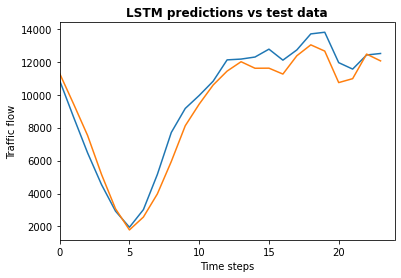

In [ ]:
# LSTM model (1HL) predictions vs test data

plt.xlim(0,24)
plt.plot(np.transpose(y_test_pred), label="LSTM_predictions")
plt.plot(np.transpose(Y_test), label = "Test data")
#plt.fill_between(x = np.arange(0,24), y1= np.transpose(lower_pred).reshape(24), y2=np.transpose(upper_pred).reshape(24), color = "b", alpha = 0.10)

# axis labels, title and legend
plt.xlabel('Time steps')
plt.ylabel("Traffic flow")
plt.title("LSTM predictions vs test data", fontweight="bold")
#legend = plt.legend(["LSTM" predictions","Test data","95% PI"],loc='lower right')

#save_results_to = '/Users/Manu/Dropbox/MScThesis-Conor-Manu/Latex/'
#tkz.save(save_results_to + "GRU_predictions.tex")

plt.show()


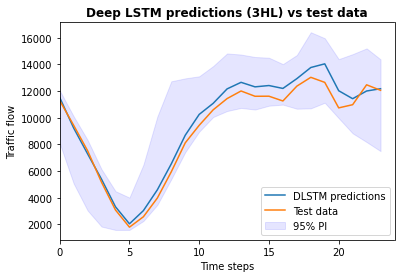

In [ ]:
# Deep GRU model (3HL) predictions vs test data

plt.xlim(0,24)
plt.plot(np.transpose(y_test_pred_deep2), label="Deep LSTM_predictions")
plt.plot(np.transpose(Y_test), label = "Test data")
plt.fill_between(x = np.arange(0,24), y1= np.transpose(lower_pred).reshape(24), y2=np.transpose(upper_pred).reshape(24), color = "b", alpha = 0.10)

# axis labels, title and legend
plt.xlabel('Time steps')
plt.ylabel("Traffic flow")
plt.title("Deep LSTM predictions (3HL) vs test data", fontweight="bold")
legend = plt.legend(["DLSTM predictions","Test data","95% PI"],loc='lower right')

#save_results_to = '/Users/Manu/Dropbox/MScThesis-Conor-Manu/Latex/'
#tkz.save(save_results_to + "GRU_predictions.tex")

plt.show()